Задача 1. Оцінювання дефолту клієнта за допомогою скорингової моделі на основі дерев рішень 
1. Для набору навчальних даних з файлу Data_Base_I.xls розбити вхідну вибірку на навчальну та тестову (для перевірки якості моделі використати не менше 10% вхідної вибірки).
2. Застосувати щонайменше 2 різних алгоритми побудови дерев рішень, побудувати дерева рішень та визначити ймовірність події – дефолту клієнта.
3. Виконати перевірку якості моделей за допомогою тестової вибірки.
4. Обчислити загальну похибку моделей (CA – common accuracy) та похибки класифікації –1-го, 2-го роду на навчальній та тестовій вибірці.
5. Побудувати скорингові моделі у вигляді дерева рішень, використовуючи різні значення порогу. При класифікації розгляньте випадки 95%, 90%, 85 та 80%.
6. Занести результати моделювання з різними порогами та різними алгоритмами побудови у порівняльну таблицю.
7. Оформити протокол у вигляді порівняння обох методів, структур дерев та зробити висновки.


In [56]:
import numpy as np
import matplotlib as plt
import tensorflow as tf
import pandas as pd

In [57]:
df = pd.read_csv('DataBase.csv')

df.head()

,Gender,Age,Сredit_sum,Currency,Term_of_crediting_in day,Interest rate_%,Duration_of_stay_in_a_sity,Maritial_status,Children,Job_position,Tenure_with_current_employer,Term_of_existence_of_enterprise,Company_type,Number_of_employees_in_kompany,Income_customer,Costs_customer,goal_credit,Result
0,Female,27,850,UAH,360,18,24_60,SINGLE,c0,PE,24_60,24_60,FS,100_9999,674,362,consumer_credit,good
1,Male,35,400,USD,240,12,24_60,SINGLE,c0,AS,24_60,24_60,FMG,51_100,690,342,consumer_credit,bad
2,Male,43,2750,UAH,240,14,24_60,MARRIED,c1,AS,12_18,12_24,OT,31_50,1588,767,consumer_credit,good
3,Male,43,15000,USD,1800,15,60_120,MARRIED,c1,TM,24_60,24_60,OT,0_5,4869,800,consumer_credit,bad
4,Male,28,2500,UAH,1080,18,60_120,SINGLE,c0,PE,0_3,0_12,FS,100_9999,637,382,consumer_credit,good


In [58]:
df.isnull().sum().sum()

0

There are no missing values in this dataset

In [59]:
df.apply(lambda x: x.unique())

Gender                                                                [Female, Male]
Age                                [27, 35, 43, 28, 29, 38, 33, 37, 32, 47, 41, 4...
Сredit_sum                         [850, 400, 2750, 15000, 2500, 2215, 54600, 200...
Currency                                              [UAH, USD, EUR, 0,  USD,  UAH]
Term_of_crediting_in day           [360, 240, 1800, 1080, 90, 2520, 60, 720, 1080...
Interest rate_%                    [18, 12, 14, 15, 20, 19, 22, 26, 16, 17, 23, 1...
Duration_of_stay_in_a_sity          [24_60, 60_120, 120_9999, 12_24, 6_12, 3_6, 0_3]
Maritial_status                           [SINGLE, MARRIED, DIVORCED, CIVILMARRIAGE]
Children                                                            [c0, c1, c2, c3]
Job_position                                                    [PE, AS, TM, SP, MM]
Tenure_with_current_employer       [24_60, 12_18, 0_3, 60_120, 120_9999, 3_6, 18_...
Term_of_existence_of_enterprise               [24_60, 12_24, 0_12

In [60]:
df['Currency'].replace('0', np.nan, inplace=True)

/var/folders/vg/lfx3769n7_560g_6160v_23m0000gn/T/ipykernel_15819/4275293213.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Currency'].replace('0', np.nan, inplace=True)


We see potential columns to pay attantion to

### Gender

In [61]:
df['Gender'].value_counts()

Gender
Male      8136
Female    6864
Name: count, dtype: int64

In [62]:
df = pd.get_dummies(df, columns=['Gender'])

In [63]:
df[['Gender_Female', 'Gender_Male']].head()

,Gender_Female,Gender_Male
0,True,False
1,False,True
2,False,True
3,False,True
4,False,True


### Age

<Axes: title={'center': 'Age Distribution'}, ylabel='Frequency'>

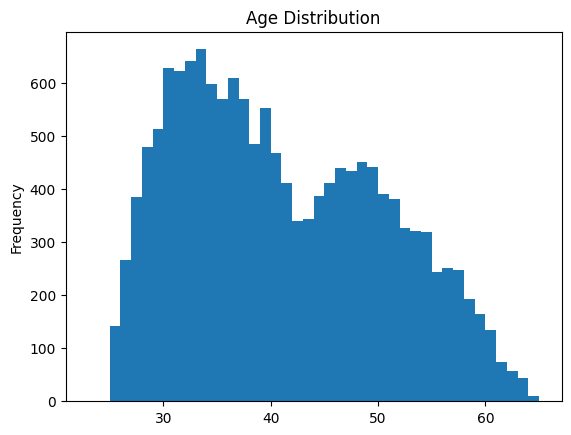

In [64]:
num_bins = len(df['Age'].unique())
df['Age'].plot(kind='hist', bins=num_bins, title='Age Distribution')

In [65]:
df['Age'].describe()

count    15000.000000
mean        40.587867
std          9.460069
min         23.000000
25%         33.000000
50%         39.000000
75%         48.000000
max         65.000000
Name: Age, dtype: float64

I will return to it later to understand if i need to categorise this feature

### Credit Sum

<Axes: title={'center': 'Credit Sum Distibution'}, ylabel='Frequency'>

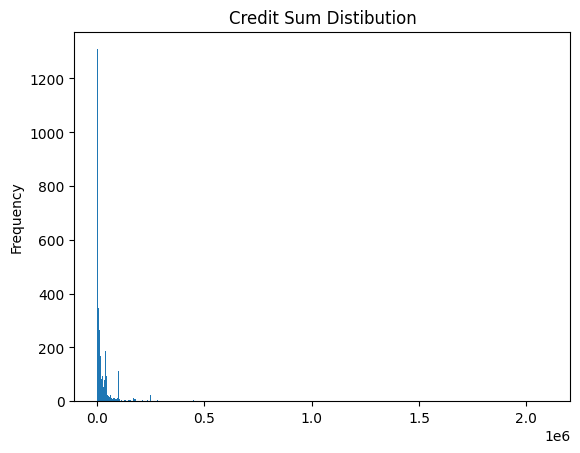

In [66]:
num_bins = len(df['Сredit_sum'].unique())
df['Сredit_sum'].plot(kind='hist', bins=num_bins, title='Credit Sum Distibution')

Normalisation/logarythmisation?

In [67]:
df['Currency'] = df['Currency'].str.strip()

In [68]:
df['Currency'].unique()

array(['UAH', 'USD', 'EUR', nan], dtype=object)

In [69]:
df['Currency'].replace('0', np.nan, inplace=True)

/var/folders/vg/lfx3769n7_560g_6160v_23m0000gn/T/ipykernel_15819/4275293213.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Currency'].replace('0', np.nan, inplace=True)


In [70]:
print(df['Currency'].unique())

['UAH' 'USD' 'EUR' nan]


In [71]:
df.loc[df['Currency'].isnull()]

,Age,Сredit_sum,Currency,Term_of_crediting_in day,Interest rate_%,Duration_of_stay_in_a_sity,Maritial_status,Children,Job_position,Tenure_with_current_employer,Term_of_existence_of_enterprise,Company_type,Number_of_employees_in_kompany,Income_customer,Costs_customer,goal_credit,Result,Gender_Female,Gender_Male
5251,44,2619,NaN,360,28,120_9999,MARRIED,c2,AS,120_9999,120_9999,OT,100_9999,1138,155,consumer_credit,good,True,False
14249,40,96000,NaN,5400,13,6_12,MARRIED,c1,AS,24_60,24_60,WB,0_5,8397,0,flat,good,True,False


In [72]:
df.dropna(subset=['Currency'], inplace=True)

In [73]:
df['Currency'].unique()

array(['UAH', 'USD', 'EUR'], dtype=object)

In [74]:
df['Location'] = df['Currency'].map({'USD': 'USA', 'UAH': 'UA', 'EUR': 'EU'})

df[['Currency', 'Location']].head()

,Currency,Location
0,UAH,UA
1,USD,USA
2,UAH,UA
3,USD,USA
4,UAH,UA


In [75]:
exchange_rates = {
    'UAH': 1,   
    'USD': 41,  
    'EUR': 46   
}

df['Credit_sum_in_UAH'] = df['Сredit_sum'] * df['Currency'].map(exchange_rates)
df['Income_in_UAH'] = df['Income_customer'] * df['Currency'].map(exchange_rates)
df['Costs_in_UAH'] = df['Costs_customer'] * df['Currency'].map(exchange_rates)

df[['Сredit_sum', 'Income_customer', 'Costs_customer', 'Currency', 'Credit_sum_in_UAH', 'Income_in_UAH', 'Costs_in_UAH']].head()

,Сredit_sum,Income_customer,Costs_customer,Currency,Credit_sum_in_UAH,Income_in_UAH,Costs_in_UAH
0,850,674,362,UAH,850,674,362
1,400,690,342,USD,16400,28290,14022
2,2750,1588,767,UAH,2750,1588,767
3,15000,4869,800,USD,615000,199629,32800
4,2500,637,382,UAH,2500,637,382


In [76]:
df.drop(columns=['Сredit_sum', 'Income_customer', 'Costs_customer', 'Currency'], inplace=True)

In [77]:
df.apply(lambda x: x.unique())

Age                                [27, 35, 43, 28, 29, 38, 33, 37, 32, 47, 41, 4...
Term_of_crediting_in day           [360, 240, 1800, 1080, 90, 2520, 60, 720, 1080...
Interest rate_%                    [18, 12, 14, 15, 20, 19, 22, 26, 16, 17, 23, 1...
Duration_of_stay_in_a_sity          [24_60, 60_120, 120_9999, 12_24, 6_12, 3_6, 0_3]
Maritial_status                           [SINGLE, MARRIED, DIVORCED, CIVILMARRIAGE]
Children                                                            [c0, c1, c2, c3]
Job_position                                                    [PE, AS, TM, SP, MM]
Tenure_with_current_employer       [24_60, 12_18, 0_3, 60_120, 120_9999, 3_6, 18_...
Term_of_existence_of_enterprise               [24_60, 12_24, 0_12, 120_9999, 60_120]
Company_type                       [FS, FMG, OT, WB, EC, HI, MPP, ASTL, EOG, ITT,...
Number_of_employees_in_kompany                  [100_9999, 51_100, 31_50, 0_5, 6_15]
goal_credit                        [consumer_credit, flat, house,